# Time Series on Other Data Sets
---

The aim of this notebook is to test the robustness and generalizability of the developed GP model on other datasets such as website traffic on wikipedia, milk production, etc.

# Long-range Forecasting and Pattern Discovery given Limited Data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
# import theano
# import theano.tensor as tt
# import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
# from bqplot import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from beakerx import *
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 20, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gpflow
from gpflowopt.domain import ContinuousParameter
from gpflowopt.bo import BayesianOptimizer
from gpflowopt.acquisition import ExpectedImprovement, MinValueEntropySearch
from gpflowopt.optim import StagedOptimizer, MCOptimizer, SciPyOptimizer  
from gpflowopt.design import LatinHyperCube
import random
random.seed(1234)

/Users/demaasit/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# import rpy2
# %load_ext rpy2.ipython
# import warnings
# warnings.filterwarnings("ignore")

## Data Preparation

In [39]:
web_data = pd.read_csv("../../data/web_traffic.csv")

In [64]:
# web_data.columns = ["ds", "y"]
web_series = web_data.iloc[0]
df = pd.DataFrame(web_series).reset_index().drop([0]).columns = ["ds", "y"]
df.head()

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 1 to 550
Data columns (total 2 columns):
ds    550 non-null object
y     550 non-null object
dtypes: object(2)
memory usage: 12.9+ KB


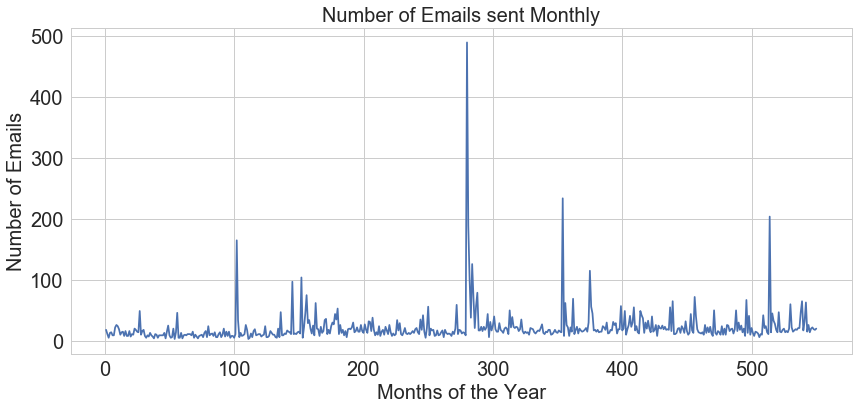

In [69]:
fig, ax = plt.subplots()
ax.plot(df.index, df.y)
# ax.set_xticklabels(labels = df.ds, rotation = 45)
ax.set_xlabel("Months of the Year")
ax.set_ylabel("Number of Emails")
ax.set_title("Number of Emails sent Monthly");

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 1 to 550
Data columns (total 2 columns):
ds    550 non-null object
y     550 non-null object
dtypes: object(2)
memory usage: 12.9+ KB


In [71]:
X_complete = np.array([df.index]).reshape((550, 1)).astype('float64')
X_train = X_complete[0:300, ]
X_test = X_complete[300:550, ]
Y_complete = np.array([df.y]).reshape((550, 1)).astype('float64')
Y_train = Y_complete[0:300, ]
Y_test = Y_complete[300:550, ]
D = Y_train.shape[1];

In [72]:
D

1

In [73]:
Y_train.shape; X_train.shape; Y_test.shape; X_test.shape; X_complete.shape

(300, 1)

(300, 1)

(250, 1)

(250, 1)

(550, 1)

In [74]:
Y_train[0:3, ]; X_train[0:3, ]; Y_test[0:3, ]; X_test[0:3, ]; X_complete[0:3, ]

array([[ 18.],
       [ 11.],
       [  5.]])

array([[ 1.],
       [ 2.],
       [ 3.]])

array([[ 40.],
       [ 19.],
       [ 15.]])

array([[ 301.],
       [ 302.],
       [ 303.]])

array([[ 1.],
       [ 2.],
       [ 3.]])

In [75]:
Y_train.dtype

dtype('float64')

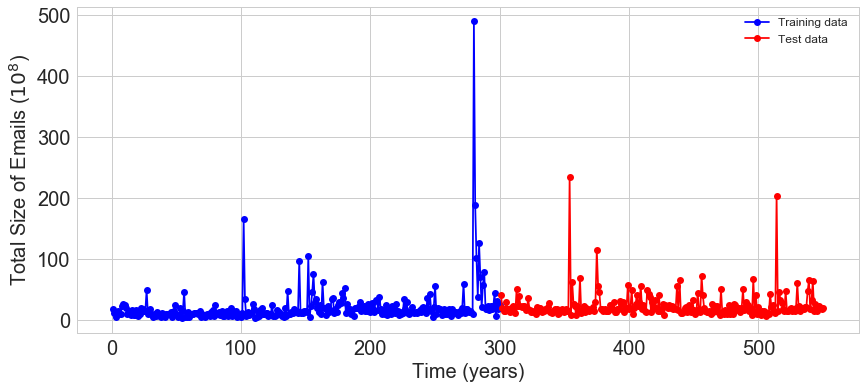

In [76]:
fig, ax = plt.subplots()
ax.plot(X_train.flatten(),Y_train.flatten(), c ='b', marker = "o", label = "Training data")
ax.plot(X_test.flatten(),Y_test.flatten(), c='r', marker = "o", label = 'Test data')
# ax.set_xticklabels([1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010])
ax.set_xlabel('Time (years)')
ax.set_ylabel('Total Size of Emails ($10^8$)')
plt.legend(loc = "best");
# fig1 = plt.gcf()
# py.offline.iplot_mpl(fig1);

## Gaussian Process modeling

This study used a Gaussian Process model with a Spectral Mixture (SM) kernel proposed by Wilson (2014). This is because the SM kernel is capable of capturing hidden structure with data without hard cording features in a kernel. Moreover, the SM kernel is capable of performing long-range extrapolation beyond available data.


In [77]:
# Trains a model with a spectral mixture kernel, given an ndarray of 
# 2Q frequencies and lengthscales

Q = 10 # nr of terms in the sum
max_iters = 1000

def create_model(hypers):
    f = np.clip(hypers[:Q], 0, 5)
    weights = np.ones(Q) / Q
    lengths = hypers[Q:]

    kterms = []
    for i in range(Q):
        rbf = gpflow.kernels.RBF(D, lengthscales=lengths[i], variance=1./Q)
        rbf.lengthscales.transform = gpflow.transforms.Exp()
        cos = gpflow.kernels.Cosine(D, lengthscales=f[i])
        kterms.append(rbf * cos)

    k = np.sum(kterms) + gpflow.kernels.Linear(D) + gpflow.kernels.Bias(D)
    m = gpflow.gpr.GPR(X_train, Y_train, kern=k)
    return m

m = create_model(np.ones((2*Q,)))

In [78]:
%%time
m.optimize(maxiter = max_iters)

      fun: 1468.8439541297207
 hess_inv: <43x43 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.76732327e-05,  -1.53058795e-05,  -1.91908328e-08,
         3.27632613e-05,  -2.28588696e-05,   3.65335598e-05,
        -1.91908328e-08,   3.27632613e-05,  -2.28588696e-05,
         3.65335598e-05,  -1.91908328e-08,   3.27632613e-05,
        -2.28588696e-05,   3.65335598e-05,  -1.91908328e-08,
         3.27632613e-05,  -2.28588696e-05,   3.65335598e-05,
        -1.91908328e-08,   3.27632613e-05,  -2.28588696e-05,
         3.65335598e-05,  -1.91908328e-08,   3.27632613e-05,
        -2.28588696e-05,   3.65335598e-05,  -1.91908328e-08,
         3.27632613e-05,  -2.28588696e-05,   3.65335598e-05,
        -1.91908328e-08,   3.27632613e-05,  -2.28588696e-05,
         3.65335598e-05,  -1.91908328e-08,   3.27632613e-05,
        -2.28588696e-05,   3.65335598e-05,  -1.91908328e-08,
         3.27632613e-05,  -2.28588696e-05,   3.65335598e-05,
        -3.42198467e-04])
  message: b'CONVERGE

In [79]:
def plotprediction(m):
    # Perform prediction
    mu, var = m.predict_f(X_complete)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
#     ax.set_xticklabels([1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020])
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Total Size of Emails ($10^8$)');
    ax.plot(X_train.flatten(),Y_train.flatten(), c='b', marker = "o", label = 'Training data')
    ax.plot(X_test.flatten(),Y_test.flatten(), c='r', marker = "o", label = 'Test data')
    ax.plot(X_complete.flatten(), mu.flatten(), c='g', label = "Predicted mean function")
    lower = mu - 2*np.sqrt(var)
    upper = mu + 2*np.sqrt(var)
    ax.plot(X_complete, upper, 'g--', X_complete, lower, 'g--', lw=1.2)
    ax.fill_between(X_complete.flatten(), lower.flatten(), upper.flatten(),
                    color='g', alpha=.1, label = "95% Predicted Credible interval")
    plt.legend(loc = "best")
    plt.tight_layout()

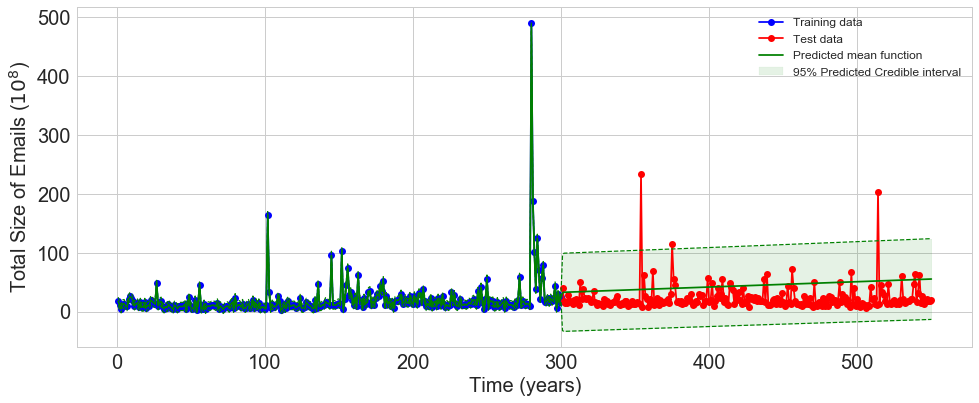

In [80]:
plotprediction(m);

## Perform hyperparameter tuning using Bayesian Optimization

Let's use Bayesian Optimization to find the optimal model parameters of the GP model and then use then to estimate the model and prediction.

In [82]:
from gpflowopt.objective import batch_apply

# Objective function for our optimization
# Input: N x 2Q ndarray, output: N x 1.
# returns the negative log likelihood obtained by training with given frequencies and rbf lengthscales
# Applies some tricks for stability similar to GPy's jitchol
@batch_apply
def objectivefx(freq):
    m = create_model(freq)
    for i in [0] + [10**exponent for exponent in range(6,1,-1)]:
        try:
            mean_diag = np.mean(np.diag(m.kern.compute_K_symm(X_train)))
            m.likelihood.variance = 1 + mean_diag * i
            m.optimize(maxiter=max_iters)
            return -m.compute_log_likelihood()
        except:
            pass
    raise RuntimeError("Frequency combination failed indefinately.")

# Setting up optimization domain.
lower = [0.]*Q
upper = [5.]*int(Q)
df = np.sum([ContinuousParameter('freq{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])

lower = [1e-5]*Q
upper = [300]*int(Q)
dl = np.sum([ContinuousParameter('l{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])
domain = df + dl
domain

Name,Type,Values
freq0,Continuous,[ 0. 5.]
freq1,Continuous,[ 0. 5.]
freq2,Continuous,[ 0. 5.]
freq3,Continuous,[ 0. 5.]
freq4,Continuous,[ 0. 5.]
freq5,Continuous,[ 0. 5.]
freq6,Continuous,[ 0. 5.]
freq7,Continuous,[ 0. 5.]
freq8,Continuous,[ 0. 5.]
freq9,Continuous,[ 0. 5.]


In [83]:
%%time
design = LatinHyperCube(6, domain)
X = design.generate()

In [84]:
%%time
Y = objectivefx(X)

/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:112: RuntimeWarning: divide by zero encountered in log
  return np.log(y - self._lower)


In [85]:
%%time
k_surrogate = gpflow.kernels.Matern52(input_dim = domain.size, ARD = False)

In [86]:
%%time
model_surrogate = gpflow.gpr.GPR(X, Y, kern = k_surrogate)

In [87]:
%%time
acq_fn = ExpectedImprovement(model_surrogate)
# acq_fn = MinValueEntropySearch(model_surrogate, domain = domain)

In [88]:
%%time
acq_optimizer = StagedOptimizer([MCOptimizer(domain, nsamples = 5000), 
                                SciPyOptimizer(domain)])

In [89]:
%%time
optimizer = BayesianOptimizer(domain = domain, 
                              acquisition = acq_fn, 
                              optimizer = acq_optimizer)

In [90]:
%%time
with optimizer.silent():
    result = optimizer.optimize(objectivefx = objectivefx, n_iter = 30)

/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:181: RuntimeWarning: invalid value encountered in maximum
  ys = np.maximum(y - self._lower, np.finfo(np_float_type).eps)


In [91]:
print(result)

     fun: array([ 1460.88540468])
 message: 'OK'
    nfev: 30
 success: True
       x: array([[  3.36391196e+00,   3.44722707e+00,   2.91498748e+00,
          1.79021968e+00,   2.81699404e-01,   4.76996114e+00,
          3.96000964e+00,   2.23293356e+00,   3.78787817e+00,
          6.36466356e-01,   2.34696154e+02,   1.41529961e+02,
          1.22528619e+02,   4.49156108e+01,   1.00000000e-05,
          1.19561865e+02,   1.43743219e+02,   2.85022285e+02,
          3.00000000e+02,   3.00000000e+02]])


In [92]:
%%time
m_opt = create_model(result.x[0,:])
m_opt.optimize()

      fun: 1461.2591269560114
 hess_inv: <43x43 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.03036270e-02,  -1.45765629e-01,   3.50014433e+01,
        -3.07759724e-02,  -1.39488889e-03,  -3.71133652e-02,
        -4.32602487e-02,  -5.83445610e-02,  -5.62385688e-02,
        -9.98108874e-02,  -2.67071087e+00,  -3.98518794e-02,
        -3.17702099e-02,  -6.33143765e-02,  -1.32614344e+00,
         3.49701201e-02,   6.91966971e-05,   3.53239658e-02,
         1.37385117e-02,   7.20598999e-02,   6.84366839e-01,
         7.21810010e-02,  -0.00000000e+00,   9.45988259e-02,
        -0.00000000e+00,   9.34172948e-02,  -2.19313255e-03,
        -8.16164526e-02,  -3.00685252e-01,  -8.28153735e-02,
         4.10802336e-01,  -5.16030598e-02,   2.61316636e-05,
        -7.65756483e-02,   3.91874814e-02,  -1.08139791e-03,
         2.36876321e-02,  -1.85259885e-03,  -1.98283027e+00,
        -5.09332630e-02,  -1.93567307e-02,  -8.78157986e-02,
         3.90962548e-03])
  message: b'STOP: TO

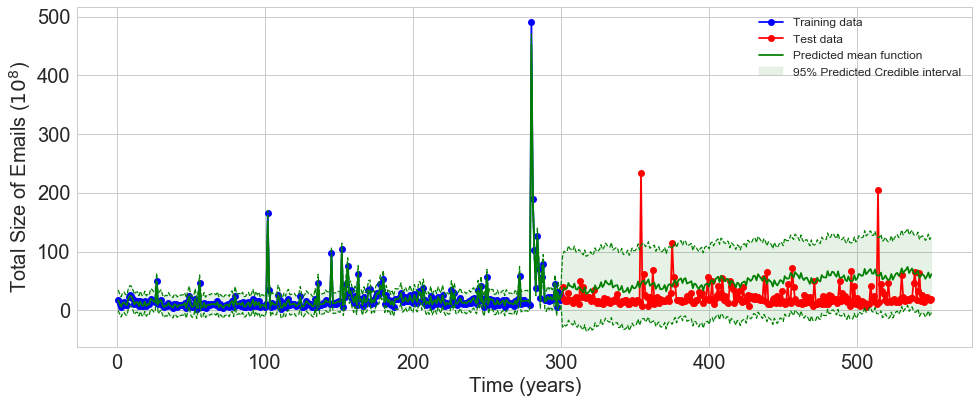

In [93]:
plotprediction(m_opt)

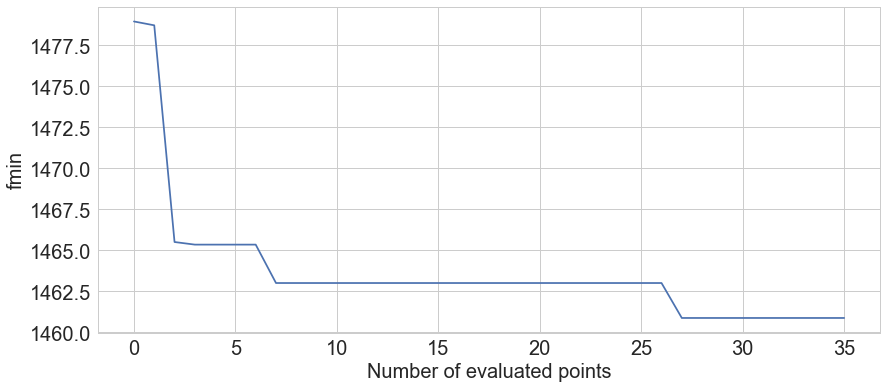

In [94]:
## Inspect the evolution
f, axes = plt.subplots()
f = acq_fn.data[1][:,0]
axes.plot(np.arange(0, acq_fn.data[0].shape[0]), np.minimum.accumulate(f))
axes.set_ylabel('fmin')
axes.set_xlabel('Number of evaluated points');

In [95]:
# # save the model and results to the files 'model.pkl' model_optimized.pkl'
# # and 'results.pkl' for later use
# with open('model_web.pkl', 'wb') as mdl:
#     pickle.dump(m, mdl, protocol = pickle.HIGHEST_PROTOCOL)
    
# with open('model_optimized_web.pkl', 'wb') as mdl_opt:
#     pickle.dump(m_opt, mdl_opt, protocol = pickle.HIGHEST_PROTOCOL)    
    
# with open('result_optimized_web.pkl', 'wb') as res:
#     pickle.dump(result, res, protocol = pickle.HIGHEST_PROTOCOL)
    
# with open('acq_fn_web.pkl', 'wb') as acq:
#     pickle.dump(acq_fn, acq, protocol = pickle.HIGHEST_PROTOCOL)        

In [60]:
# # load it at some future point
# with open('model.pkl', 'rb') as mdl:
#     m = pickle.load(mdl)

# with open('model_optimized.pkl', 'rb') as mdl_opt:
#     m_opt = pickle.load(mdl_opt)
    
# with open('result_optimized.pkl', 'rb') as res:
#     result = pickle.load(res)    

In [11]:
# improve quality of figure for journal paper
%config InlineBackend.figure_format = "retina" 

In [41]:
# print system information/setup
%reload_ext watermark
%watermark -v -m -p numpy,pandas,gpflowopt,gpflow,tensorflow,matplotlib,ipywidgets,beakerx,seaborn -g

CPython 3.6.3
IPython 6.2.1

numpy 1.13.3
pandas 0.20.3
gpflowopt 0.1.0
gpflow 0.4.0
tensorflow 1.4.1
matplotlib 2.1.1
ipywidgets 7.1.1
beakerx 0.12.1
seaborn 0.8.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ec4acbc8fd100b0026f5bfc545a6efeb4a191b89


## Bayesian Structural Time Series (BSTS)

Load the required libraries

In [40]:
%%R
library(knitr)
library(tidyverse)
# library(bsts)
library(forecast)
library(reshape2)

Prepare the data by creating a time series object.

In [41]:
%%R
#library(tidyverse, lib.loc = '/home/emaasit/anaconda3/lib/R/library')
raw_data <- read_csv("fatalities.csv")
t <- raw_data$Fatalities
ts_data <- ts(t, start = 1970, end = 2015, frequency = 1)

The years of 2013 to 2015 was used as holdout period for validation.

In [42]:
%%R
Y <- window(ts_data, start=c(1970, 1), end=c(2012,1))
y <- log10(Y)

Visualize the raw data

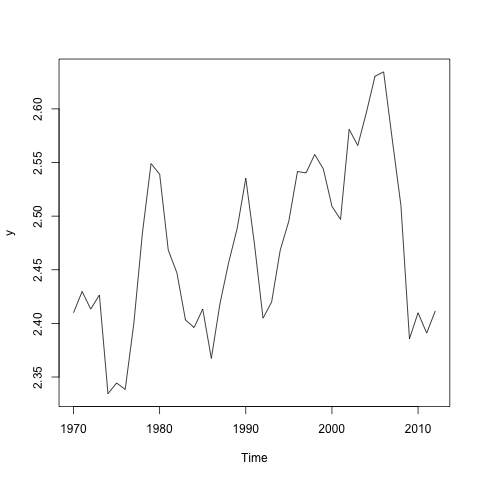

In [43]:
%R plot(y)

Run the bsts model. Given that the data is of low resolution, we cannot analyse seasonality. That is, we don't have monthly observations.

### Run the bsts model

In [9]:
%%R
ss <- AddLocalLinearTrend(list(), y)
fit_bsts <- bsts(y, state.specification = ss, niter = 1000, ping = 0, seed = 2017)

### Get a suggested number of burn-ins
burn <- SuggestBurn(0.1, fit_bsts)

### Predict
pred <- predict.bsts(fit_bsts, horizon = 3, burn = burn, quantiles = c(.025, .975))

### Actual versus predicted
d2 <- data.frame(
    # fitted values and predictions
    c(10^as.numeric(-colMeans(fit_bsts$one.step.prediction.errors[-(1:burn),])+y),  
    10^as.numeric(pred$mean)),
    # actual data and dates 
    as.numeric(ts_data),
    as.Date(time(ts_data)))
names(d2) <- c("Fitted", "Actual", "Date")

Visualize the fitted versus actual data

In [11]:
%R tail(d2)

,Fitted,Actual,Date
41,197.874193,257.0,14610.0
42,238.708284,246.0,14975.0
43,235.397245,258.0,15340.0
44,258.442150,262.0,15706.0
45,262.929669,291.0,16071.0
46,266.741803,321.0,16436.0


### Validation

Calculate the mean absolute percentage error from this model.

In [13]:
%%R
### MAPE (mean absolute percentage error)
MAPE_bsts <- filter(d2, lubridate::year(Date)>2012) %>% 
  summarise(MAPE=mean(abs(Actual-Fitted)/Actual))
MAPE_bsts

        MAPE
1 0.09302328


Visualize the fitted vs the actual including uncertainty intervals for the holdout/prediction periods.

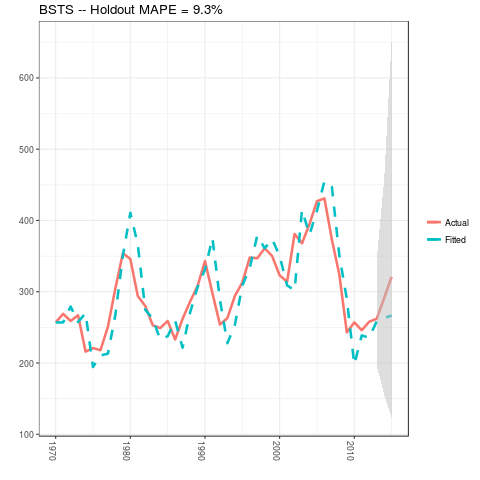

In [14]:
%%R
### 95% forecast credible interval
posterior.interval <- cbind.data.frame(
  10^as.numeric(pred$interval[1,]),
  10^as.numeric(pred$interval[2,]), 
  subset(d2, lubridate::year(Date)>2012)$Date)
names(posterior.interval) <- c("LL", "UL", "Date")

### Join intervals to the forecast
d3 <- left_join(d2, posterior.interval, by="Date")

### Plot actual versus predicted with credible intervals for the holdout period
ggplot(data=d3, aes(x=Date)) +
  geom_line(aes(y=Actual, colour = "Actual"), size=1.2) +
  geom_line(aes(y=Fitted, colour = "Fitted"), size=1.2, linetype=2) +
  theme_bw() + theme(legend.title = element_blank()) + ylab("") + xlab("") +
  geom_vline(xintercept=as.numeric(as.Date("1959-12-01")), linetype=2) + 
  geom_ribbon(aes(ymin=LL, ymax=UL), fill="grey", alpha=0.5) +
  ggtitle(paste0("BSTS -- Holdout MAPE = ", round(100*MAPE_bsts,2), "%")) +
  theme(axis.text.x=element_text(angle = -90, hjust = 0))

### Visualise Components

Moreover, one of the big advantages of the Bayesian structural model is that we can visualize the underlying components. In this example, we’re using ggplot to plot the average of the MCMC draws for the trend components:

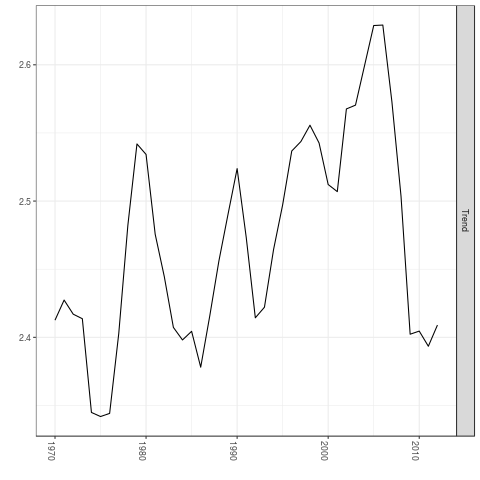

In [15]:
%%R
### Extract the components
components <- cbind.data.frame(
  colMeans(fit_bsts$state.contributions[-(1:burn),"trend",]),                               
  #colMeans(fit_bsts$state.contributions[-(1:burn),"seasonal.12.1",]),
  as.Date(time(Y)))  
#names(components) <- c("Trend", "Seasonality", "Date")
names(components) <- c("Trend", "Date")
components <- melt(components, id="Date")
names(components) <- c("Date", "Component", "Value")

### Plot
ggplot(data=components, aes(x=Date, y=Value)) + geom_line() + 
  theme_bw() + theme(legend.title = element_blank()) + ylab("") + xlab("") + 
  facet_grid(Component ~ ., scales="free") + guides(colour=FALSE) + 
  theme(axis.text.x=element_text(angle = -90, hjust = 0))

## Autoregressive Integrated Moving Average (ARIMA)

### Fit the ARIMA model

In [16]:
%%R
fit_arima <- arima(log10(Y), 
               order=c(0, 1, 1), 
               seasonal=list(order=c(0,1,1), period=1))

### Actual versus predicted
d1 <- data.frame(c(10^as.numeric(fitted(fit_arima)), # fitted and predicted
                   10^as.numeric(predict(fit_arima, n.ahead = 3)$pred)),
                   as.numeric(ts_data), #actual values
                   as.Date(time(ts_data)))
names(d1) <- c("Fitted", "Actual", "Date")


Error in data.frame(c(10^as.numeric(fitted(fit_arima)), 10^as.numeric(predict(fit_arima,  : 
  arguments imply differing number of rows: 3, 46


Visualize the fitted versus actual data

In [ ]:
%R kable(tail(d1))

### Validation

Calculate the mean absolute percentage error from ARIMA.

In [ ]:
%%R
### MAPE (mean absolute percentage error)
MAPE_arima <- filter(d1, lubridate::year(Date)>2012) %>% 
  summarise(MAPE=mean(abs(Actual-Fitted)/Actual))
MAPE_arima

Visualize the fitted vs the actual. ARIMA does not produce uncertainty intervals for the holdout/prediction periods.

In [ ]:
%%R
### Plot actual versus predicted
ggplot(data=d1, aes(x=Date)) +
  geom_line(aes(y=Actual, colour = "Actual"), size=1.2) +
  geom_line(aes(y=Fitted, colour = "Fitted"), size=1.2, linetype=2) +
  theme_bw() + theme(legend.title = element_blank()) + 
  ylab("") + xlab("") +
  geom_vline(xintercept=as.numeric(as.Date("1959-12-01")), linetype=2) +
  ggtitle(paste0("ARIMA -- Holdout MAPE = ", round(100*MAPE_arima,2), "%")) + 
  theme(axis.text.x=element_text(angle = -90, hjust = 0))